In [11]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.1.0
Hub version: 0.9.0
GPU is NOT AVAILABLE


In [12]:
module_selection = ("mobilenet_v2_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [13]:
data_dir = 'C:\\Users\\Mehmet\\glovesDetection\\dataset\\cropped'

In [14]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 208 images belonging to 2 classes.
Found 835 images belonging to 2 classes.


In [15]:
do_fine_tuning = False

In [17]:
print("Building model with", MODULE_HANDLE)
num_classes = 2

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu',input_shape=(224, 224, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
______________________________

In [18]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [19]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 26 steps, validate for 6 steps
Epoch 1/5
26/26 [==============================] - 184s 7s/step - loss: 0.5547 - accuracy: 0.7272 - val_loss: 0.4037 - val_accuracy: 0.8490
Epoch 2/5
26/26 [==============================] - 158s 6s/step - loss: 0.4912 - accuracy: 0.8107 - val_loss: 0.4235 - val_accuracy: 0.8438
Epoch 3/5
26/26 [==============================] - 162s 6s/step - loss: 0.4655 - accuracy: 0.8244 - val_loss: 0.4064 - val_accuracy: 0.9010
Epoch 4/5
26/26 [==============================] - 162s 6s/step - loss: 0.3877 - accuracy: 0.8991 - val_loss: 0.3179 - val_accuracy: 0.9427
Epoch 5/5
26/26 [==============================] - 161s 6s/step - loss: 0.3525 - accuracy: 0.9203 - val_loss: 0.3121 - val_accuracy: 0.9479


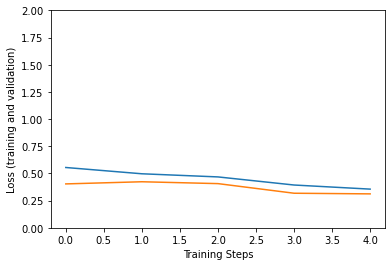

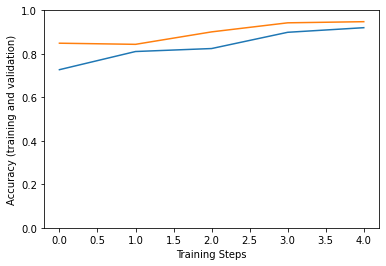

In [20]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

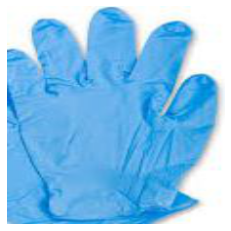

True label: gloves
Predicted label: gloves


In [21]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [29]:
saved_model_path = "C:/Users/Mehmet/glovesDetection_git/saved_model2"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: C:/Users/Mehmet/glovesDetection/saved_model\assets


INFO:tensorflow:Assets written to: C:/Users/Mehmet/glovesDetection/saved_model\assets
